In [47]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import sfp
%matplotlib inline

Failed to import duecredit due to No module named 'duecredit'


# Neuron simulations

What happens when you have a bunch of neurons in a voxel, each of which has a spatial frequency tuning curve, and you make a recording that averages over their responses (i.e., the BOLD signal)? This averaged signal will also have a spatial frequency tuning curve, but what's the relationship between the peak of the neurons and the peak of the averaged signal?

Actually, the average of a bunch of log-normal distributions is not even a log-normal distribution (though the geometric mean is). So...

In [132]:
# for now, let's ignore orientation and polar angle
neuron_eccen = [1.5, 1.25, 1.6, 1.4, 2, 5, 10, 20]
# for now, say their preferences are captured by the model
model = sfp.model.LogGaussianDonut(vary_amplitude=False, sigma=1, sf_ecc_slope=.5, sf_ecc_intercept=.2)

In [146]:
preferred_sfs = model.preferred_sf(0, neuron_eccen, 0).detach().numpy()
print(preferred_sfs)

[1.0526316  1.2121212  1.         1.1111112  0.8333333  0.37037036
 0.1923077  0.09803922]


In [134]:
sfs = np.logspace(-4, 4, 1000, base=2)
resps = np.array([model.evaluate(sfs, 0, e, 0).detach().numpy() for e in neuron_eccen])

Okay, so from this it's clear that the peak of the mean of the averaged tuning curves is not the same as the mean of the peaks of the tuning curves, which is what you'd expect. They're close if the tuning curves are all very similar but, even at one eccentricity, that's not what the neuronal data looks like (see next section).

That is:

$\arg\max\left(\frac{1}{n}\sum_{i=1}^n \exp\frac{-\log_2(\frac{\omega}{p_i})^2}{2\sigma^2}\right) \neq \frac{1}{n}\sum_{i=1}^{n} \arg\max\left(\exp\frac{-\log_2(\frac{\omega}{p_i})^2}{2\sigma^2}\right)=\frac{1}{n}\sum_{i=1}^n p_i$

In [140]:
from scipy import stats

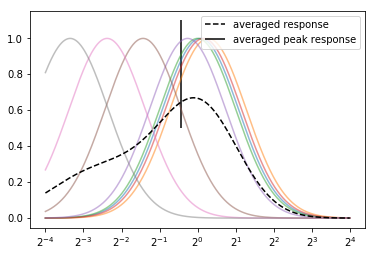

In [147]:
plt.semilogx(sfs, resps.T, basex=2,  alpha=.5);
plt.semilogx(sfs, np.mean(resps, 0),'k--', label='averaged response', basex=2,);
plt.vlines(np.mean(preferred_sfs), .5, 1.1, label='averaged peak response')
plt.legend()

In [155]:
np.mean(preferred_sfs)

0.7337393

In [154]:
sfs[np.mean(resps, 0).argmax()]

0.9278039490348006

However, it does hold for the geometric mean. That doesn't help us much, since we don't think that's what BOLD is doing to neurons, but good to know

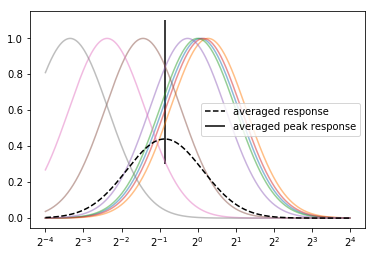

In [148]:
plt.semilogx(sfs, resps.T, basex=2,  alpha=.5);
plt.semilogx(sfs, stats.mstats.gmean(resps, 0),'k--', label='averaged response', basex=2,);
plt.vlines(stats.mstats.gmean(preferred_sfs), .3, 1.1, label='averaged peak response')
plt.legend()

In [152]:
stats.mstats.gmean(preferred_sfs)

0.5489767

In [153]:
sfs[stats.mstats.gmean(resps, 0).argmax()]

0.5475760040558576

# Examining the monkey data

In [48]:
model = sfp.model.LogGaussianDonut(vary_amplitude=False, sigma=1, sf_ecc_slope=.5, sf_ecc_intercept=.2)

In [44]:
df = pd.read_csv("../data/physiology/v1-jrc.csv")
df = df.rename(columns=lambda x: x.strip())
df = df[['Casename', 'LAYER', 'HEMI', 'rfeccen', 'complexity', 'class(s1,c0)', 'prefori', 'direct', 'oriwid', 'vectprefori', 'vectprefdir', 'vectoribias', 'vectdirbias', 'optsf', 'sfwid', 'sfqual', 'opttf', 'tfwid', 'tfqual']]
df = df.applymap(lambda x: {'#VALUE!': np.nan}.get(x,x))
df = df.dropna(subset=['optsf', 'rfeccen'])
df.rfeccen = df.rfeccen.astype(float)
df['preferred_period'] = 1./df.optsf
df['cell_class'] = df['class(s1,c0)'].apply(lambda x: {1.0: 'complex', 0.0: 'simple'}.get(x,x))
df['cell_layer'] = df.LAYER.apply(lambda x: {1.0: '1', 2.0: '2', 3.0: '3', 23.0: '2/3', 24.0: '2/4', 41.0: '4a', 42.0: '4b', 43.0: '4c', 50.: '5', 60.: '6'}.get(x, x))
layer_order = ['1', '2', '2/3', '3', '2/4', '4a', '4b', '4c', '5', '6']

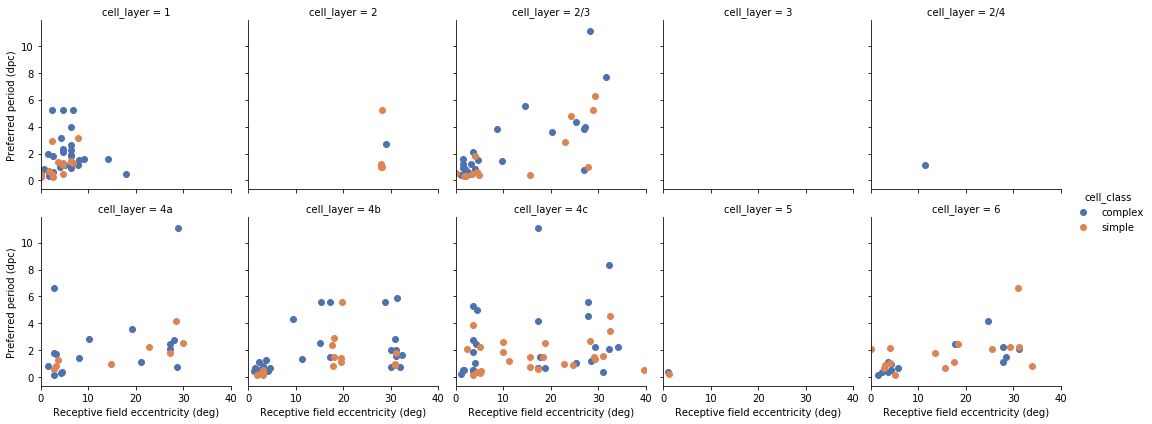

In [187]:
g = sns.FacetGrid(df, col='cell_layer', col_wrap=5, hue='cell_class', palette='deep', col_order=layer_order)
g.map(plt.scatter, 'rfeccen', 'preferred_period')
g.add_legend()
g.set_ylabels('Preferred period (dpc)')
g.set_xlabels('Receptive field eccentricity (deg)')
g.set(xlim=(0,40))
# g.fig.savefig('monkey.svg')
#for a in g.axes:
#    a.set_yscale('log', basey=2)

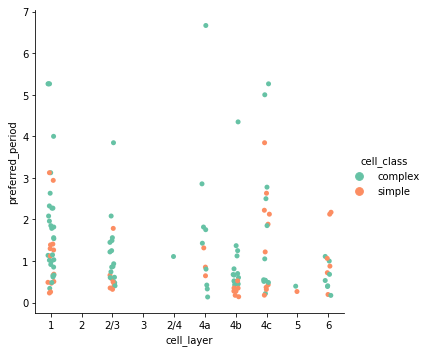

In [178]:
ax = sns.catplot('cell_layer', 'preferred_period', 'cell_class', data=df.query('rfeccen<12'), legend='full', palette='Set2', order=layer_order)

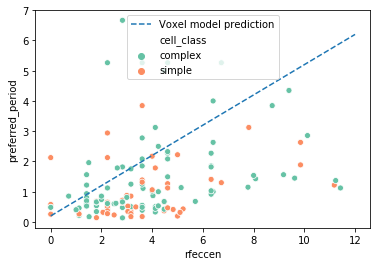

In [170]:
e = np.linspace(0, 12)
ax = sns.scatterplot('rfeccen', 'preferred_period', 'cell_class', data=df.query('rfeccen<12'), legend='full', palette='Set2',)
ax.plot(e, model.preferred_period(0, e, 0).detach().numpy(), '--', label='Voxel model prediction')
ax.legend()

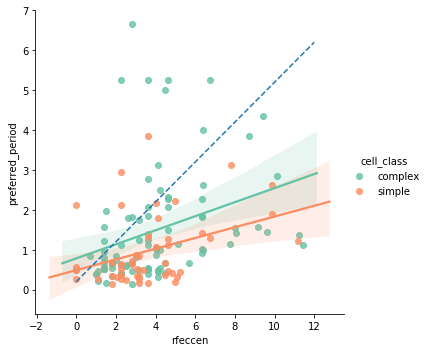

In [189]:
g = sns.lmplot('rfeccen', 'preferred_period', hue='cell_class', data=df.query('rfeccen<12'), legend='full', palette='Set2')
g.ax.plot(e, model.preferred_period(0, e, 0).detach().numpy(), '--', label='Voxel model prediction');